# DTEK0087
# Analysis and Programming for Health Wearables 2021

Lauri Orava

516761

Analysis Exercise 2

In [10]:
import pandas as pd
import numpy as np 
import scipy.signal as signal
from scipy import interpolate
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
data = os.path.join(os.getcwd(), 'data', 'ecg_ppg_clean.csv')
df = pd.read_csv(data)
df.head()

,timestamps_ecg,ecg,timestamps_ppg_1_green,ppg_1_green,timestamps_ppg_1_red,ppg_1_red,timestamps_ppg_1_ir,ppg_1_ir,timestamps_ppg_2_green,ppg_2_green,timestamps_ppg_2_red,ppg_2_red,timestamps_ppg_2_ir,ppg_2_ir
0,725290.0,-1949.000000,725314.0,31289.000000,725314.0,2.274565e+06,725314.0,2.544369e+06,725301.0,28101.000000,725301.0,2.534342e+06,725301.0,2.540145e+06
1,725368.0,-1737.708861,725414.0,31255.336634,725414.0,2.274575e+06,725414.0,2.544328e+06,725401.0,28117.666667,725401.0,2.534269e+06,725401.0,2.539954e+06
2,725446.0,-1534.215190,725514.0,31204.029703,725514.0,2.274564e+06,725514.0,2.544304e+06,725501.0,28114.156863,725501.0,2.534142e+06,725501.0,2.539586e+06
3,725524.0,-1413.556962,725614.0,31186.504950,725614.0,2.274553e+06,725614.0,2.544289e+06,725601.0,28101.764706,725601.0,2.533956e+06,725601.0,2.539082e+06
4,725602.0,-1333.050633,725714.0,31166.029412,725714.0,2.274524e+06,725714.0,2.544271e+06,725701.0,28083.490196,725701.0,2.533720e+06,725701.0,2.538444e+06


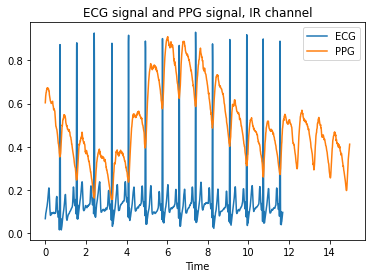

In [12]:
def normalize(sig):
    """
    Min-max normalization
    """
    sig = sig - np.min(sig)
    sig = sig/np.max(sig)
    return sig

# choose the correct channels
# normalize the signals with min-max normalization
# make the timestamps start at 0, and divide them by 10000 
# to make them easily readable
ecg_signal = normalize(df['ecg'].to_numpy())
ecg_time = (df['timestamps_ecg'].to_numpy()-df['timestamps_ecg'][0])/10000

# also do reflection for ppg; high values in the signal correspond to small amounts
# of absorbed light = little blood
# we want high amplitude = lot of blood
ir_signal = normalize(df['ppg_1_ir'].dropna().to_numpy()*-1)
ir_time = (df['timestamps_ppg_1_ir'].dropna().to_numpy()-df['timestamps_ppg_1_ir'][0])/10000


# plotting first 1000 data points
plt.plot(ecg_time[:1500],ecg_signal[:1500])
plt.plot(ir_time[:1500], ir_signal[:1500])
plt.title("ECG signal and PPG signal, IR channel")
plt.legend(['ECG', "PPG"])
plt.xlabel("Time")
plt.show()
plt.close()

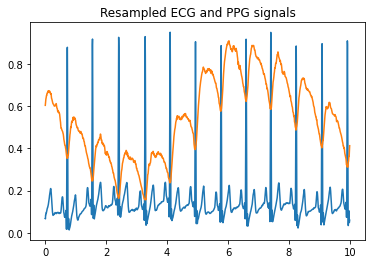

In [13]:
# find the number of needed new time stamps
fs = 200
T_ecg = ecg_time[-1]
T_ppg = ir_time[-1]
n_ecg = int(fs*T_ecg)
n_ppg = int(fs*T_ppg)


# signal.resample returns [signal, timestamps]
# resample requires number of new points, and the old timestamps
resampled_ecg = signal.resample(ecg_signal, n_ecg, ecg_time )
resampled_ppg = signal.resample(ir_signal, n_ppg, ir_time)

plt.plot(resampled_ecg[1][:2000], resampled_ecg[0][:2000])
plt.plot(resampled_ppg[1][:2000], resampled_ppg[0][:2000])
plt.title("Resampled ECG and PPG signals")
plt.show()
plt.close()

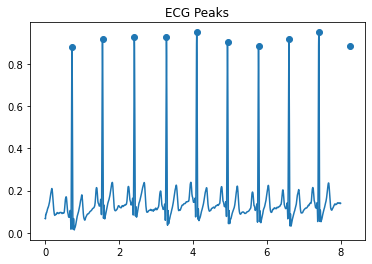

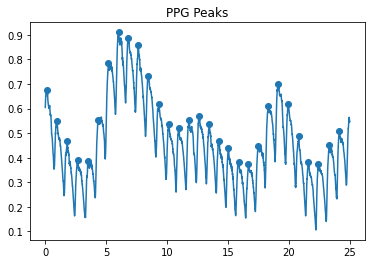

In [14]:
# 1 - Peak detection

from scipy.signal import find_peaks, argrelextrema


# calculate the peaks
# height implies the required height for each peak
peaks_indices_ecg = find_peaks(resampled_ecg[0], height=0.5)[0]
peaks_indices_ppg = find_peaks(resampled_ppg[0], distance = 150)[0]
#peaks_indices_ppg = argrelextrema(resampled_ppg[0], np.greater)

plt.plot(resampled_ecg[1][:1600], resampled_ecg[0][:1600])
plt.scatter(resampled_ecg[1][peaks_indices_ecg][:10],resampled_ecg[0][peaks_indices_ecg][:10])
plt.title("ECG Peaks")
plt.show()
plt.close()
plt.plot(resampled_ppg[1][:5000], resampled_ppg[0][:5000])
plt.scatter(resampled_ppg[1][peaks_indices_ppg][:30],resampled_ppg[0][peaks_indices_ppg][:30])
plt.title("PPG Peaks")
plt.show()

In [15]:
# 2 - Heart rate

def detect_peaks(sig, h, d):
    detected = signal.find_peaks(sig, height = h, distance = d)[0]
    return detected

def compute_heart_rate(sig, fs, h):
    peaks = detect_peaks(sig, h = h, d = None)
    return 60.0 / np.mean((np.diff(peaks / fs)))

ecg_hr = compute_heart_rate(resampled_ecg[0], 200, 0.5)
print("Heart rate:", round(ecg_hr))

Heart rate: 73


In [16]:
# 2 - Find impossible heart beat locations

rr_interval = np.mean((np.diff(peaks_indices_ecg)))
# loop over the peak indices
for i in range(len(peaks_indices_ecg)-1):
    if peaks_indices_ecg[i+1]-peaks_indices_ecg[i] < 0.8*rr_interval or peaks_indices_ecg[i+1]-peaks_indices_ecg[i] > 1.3*rr_interval:
        print("impossible heart rate at ", i)

# None found

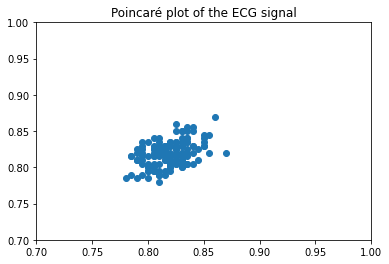

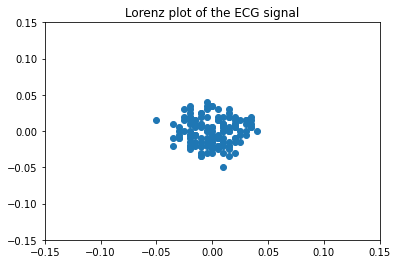

In [17]:
# 3 - Poincare & Lorenz

# Poincare points
poincare_points = np.diff(peaks_indices_ecg)/fs
# two vectors for plotting, other is one off 
poincare_points_x = poincare_points[:-1]
poincare_points_y = poincare_points[1:]

# same for Lorenz
lorenz_points = np.diff(poincare_points)

lorenz_points_x = lorenz_points[:-1]
lorenz_points_y = lorenz_points[1:]


# plot
plt.scatter(poincare_points_x, poincare_points_y)
plt.title("Poincaré plot of the ECG signal")
plt.xlim([0.7,1.])
plt.ylim([0.7,1.])
plt.show()
plt.close()
plt.scatter(lorenz_points_x, lorenz_points_y)
plt.title("Lorenz plot of the ECG signal")
plt.xlim([-0.15,0.15])
plt.ylim([-0.15,0.15])
plt.show()

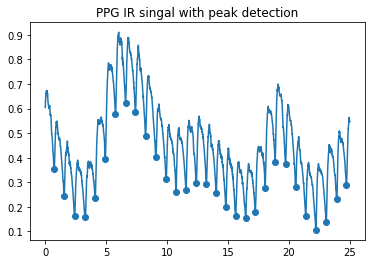

In [18]:
# calculate new peaks for -ppg (we want the onset of the peak, not the peak itself)


peaks_indices_ppg_low = find_peaks(-1*resampled_ppg[0], distance = 150)[0]
plt.plot(resampled_ppg[1][:5000], resampled_ppg[0][:5000])
plt.title("PPG IR singal with peak detection")
plt.scatter(resampled_ppg[1][peaks_indices_ppg_low][:30],resampled_ppg[0][peaks_indices_ppg_low][:30])
plt.show()

In [19]:
ecg_r_peak_indices = peaks_indices_ecg
ppg_peak_onset_indices = peaks_indices_ppg_low
ppg_peak_indices = peaks_indices_ppg

indices_between_r_peak_and_onset = ecg_r_peak_indices-ppg_peak_onset_indices
indices_between_r_peak_and_peak = ecg_r_peak_indices-ppg_peak_indices[:-1]
print("Time difference between R-peak and PPG signal onset: ",np.mean(indices_between_r_peak_and_onset)/fs)
print("Time difference between R-peak and PPG signal peak:", np.mean(indices_between_r_peak_and_peak)/fs)

Time difference between R-peak and PPG signal onset:  0.0030201342281879194
Time difference between R-peak and PPG signal peak: 0.5862080536912752
